In [14]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

In [4]:
no = pd.read_csv('no_discount.csv')
all = pd.read_csv('all_discount.csv')
half = pd.read_csv('half_discount.csv')
prod = pd.read_excel('product.xlsx')

In [5]:
dataframes = {'no': no, 'all': all, 'half': half}
user_features = ['user_feature_1', 'user_feature_2', 'user_feature_3']
feature_names = {
    'user_feature_1': 'Gender',
    'user_feature_2': 'Phone Replacement Recency',
    'user_feature_3': 'Shopping Preference'
}

In [6]:
def percent_distributions(feature):
    """计算各组中某个特征的百分比分布"""
    distributions = {}
    for name, df in dataframes.items():
        distributions[name] = df[feature].value_counts(normalize=True) * 100
    return pd.DataFrame(distributions).fillna(0).sort_index()

In [7]:
for feature in user_features:
    print(f"\nProportion of {feature_names[feature]}:")
    print(percent_distributions(feature))

print("\n" + "-"*30 + "\n")

combined = pd.concat([df.assign(group=name) for name, df in dataframes.items()])

for feature in user_features:
    ct = pd.crosstab(combined[feature], combined['group'])
    chi2, p, dof, expected = chi2_contingency(ct)

    name = feature_names[feature]
    print(f"{name}: chi2={chi2:.3f}, df={dof}, p={p:.3f}")


Proportion of Gender:
                                  no        all       half
user_feature_1                                            
Female                     51.890034  47.482014  50.375940
Male                       47.079038  51.079137  47.744361
Non-binary / third gender   0.687285   0.719424   1.503759
Prefer not to say           0.343643   0.719424   0.375940

Proportion of Phone Replacement Recency:
                                        no        all       half
user_feature_2                                                  
1-2 years ago                    25.429553  32.374101  29.699248
2-3 years ago                    28.522337  20.143885  25.939850
3-4 yeas ago                     14.432990  11.870504  11.278195
Currently, I don't have a phone   0.343643   0.000000   0.000000
Less than 1 year ago             20.274914  22.302158  19.924812
More than 4 years ago            10.996564  13.309353  13.157895

Proportion of Shopping Preference:
                         

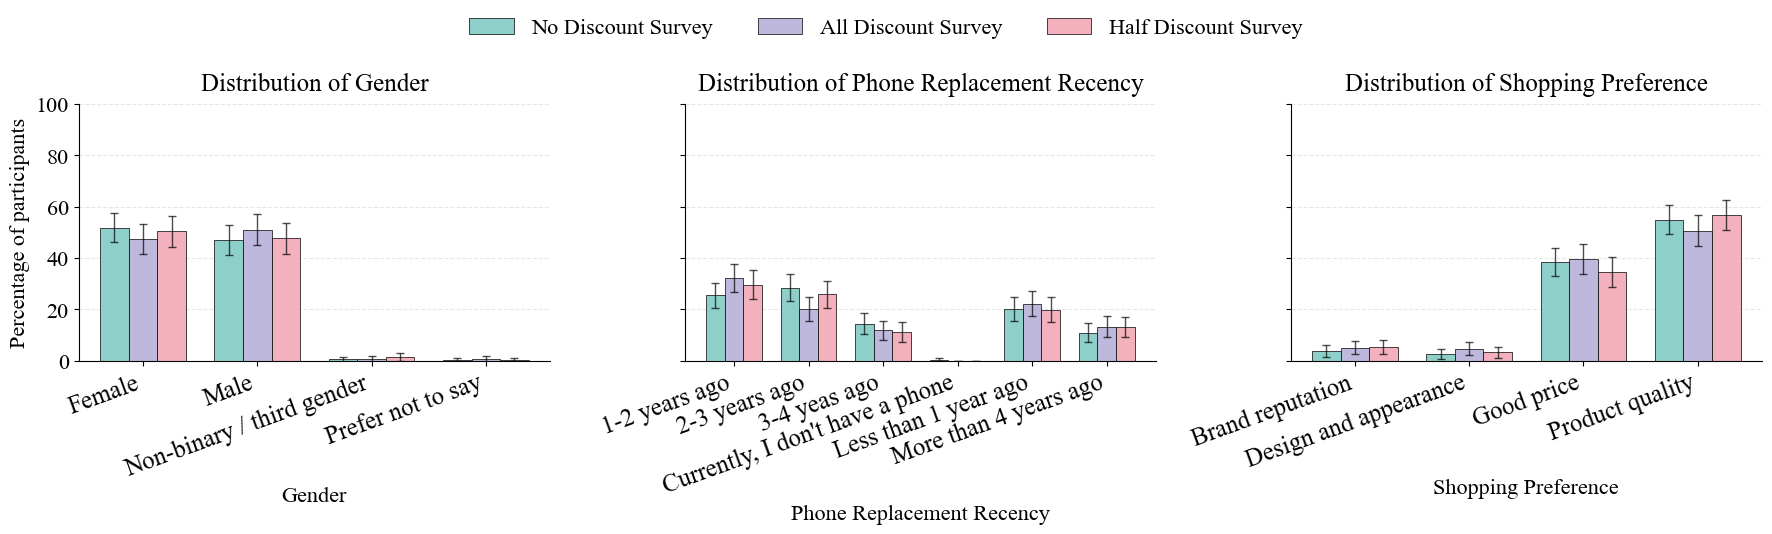

In [13]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.unicode_minus'] = False

colors = ['#8ECFC9', '#BEB8DC', '#F2B1BC']
labels = ['No Discount Survey', 'All Discount Survey', 'Half Discount Survey']
survey_dfs = [no, all, half]

features_config = [
    {
        'col': 'user_feature_1',
        'title': 'Distribution of Gender',
        'xlabel': 'Gender',
        'order': ['Female', 'Male', 'Non-binary / third gender', 'Prefer not to say']
    },
    {
        'col': 'user_feature_2',
        'title': 'Distribution of Phone Replacement Recency',
        'xlabel': 'Phone Replacement Recency',
        'order': ['1-2 years ago', '2-3 years ago', '3-4 yeas ago',
                  "Currently, I don't have a phone", 'Less than 1 year ago', 'More than 4 years ago']
    },
    {
        'col': 'user_feature_3',
        'title': 'Distribution of Shopping Preference',
        'xlabel': 'Shopping Preference',
        'order': ['Brand reputation', 'Design and appearance', 'Good price', 'Product quality']
    }
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

bar_width = 0.25
x_offsets = [-bar_width, 0, bar_width]

for idx, config in enumerate(features_config):
    ax = axes[idx]
    col = config['col']
    categories = config['order']

    x = np.arange(len(categories))

    for i, df in enumerate(survey_dfs):
        total_n = len(df)
        counts = df[col].value_counts().reindex(categories, fill_value=0)
        proportions = counts / total_n

        se = np.sqrt((proportions * (1 - proportions)) / total_n)
        ci_95 = 1.96 * se  # 95% Confidence Interval

        ax.bar(
            x + x_offsets[i],
            proportions * 100,
            width=bar_width,
            label=labels[i] if idx == 0 else "",
            color=colors[i],
            edgecolor='black',
            linewidth=0.5,
            yerr=ci_95 * 100,
            capsize=3,
            error_kw={'elinewidth': 1, 'ecolor': 'black', 'alpha': 0.7}
        )

    ax.set_title(config['title'], fontsize=18, pad=10)
    ax.set_xlabel(config['xlabel'], fontsize=16)
    if idx == 0:
        ax.set_ylabel('Percentage of participants', fontsize=16)

    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=20, ha='right', fontsize=18)

    ax.set_ylim(0, 100)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

lines, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(lines, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
           ncol=3, frameon=False, fontsize=16)

plt.tight_layout()
plt.show()

In [15]:
# Control Group (No Discount)
n_control = 291
p_control = 0.347

# Treated Group (All Discount)
n_treated = 278
p_treated = 0.500

alpha = 0.05  # Significance level

h = proportion_effectsize(p_treated, p_control)

analysis = NormalIndPower()
ratio = n_treated / n_control 

power_val = analysis.solve_power(
    effect_size=h, 
    nobs1=n_control,  
    alpha=alpha, 
    ratio=ratio,       
    alternative='two-sided'
)

n_required = analysis.solve_power(
    effect_size=h, 
    nobs1=None,   
    alpha=alpha, 
    power=0.8, 
    ratio=1.0      
)

print(f"--- Analysis Results ---")
print(f"Effect Size (Cohen's h): {h:.3f}")       
print(f"Achieved Power:          {power_val:.3f}") 
print(f"Required n for 80% Power:{n_required:.1f}")

--- Analysis Results ---
Effect Size (Cohen's h): 0.311
Achieved Power:          0.960
Required n for 80% Power:162.3
